In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    dtype='float32',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

train_set = train_datagen.flow_from_directory(
    'Train/',
    target_size=(400, 300),
    batch_size=10,
    class_mode='categorical',
    subset='training'
)

validation_set = train_datagen.flow_from_directory(
    'Train/',
    target_size=(400, 300),
    batch_size=10,
    class_mode='categorical',
    subset='validation'
)

test_set = test_datagen.flow_from_directory(
    'Test/',
    target_size=(400, 300),
    batch_size=5,
    class_mode='categorical'
)

# Define ensemble parameters
num_models = 3
ensemble_models = []
ensemble_test_accuracies = []

# Train multiple models
for i in range(num_models):
    # Build the convnet model
    network = models.Sequential()
    network.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(400, 300, 3)))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    network.add(layers.MaxPooling2D((2, 2)))
    network.add(layers.Flatten())
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(16, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    network.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    # Define the learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    # Train the model with the learning rate scheduler
    history = network.fit(train_set,
                          validation_data=validation_set,
                          epochs=10,
                          callbacks=[lr_scheduler],
                          verbose=1)

    # Evaluate the model on the validation set
    val_loss, val_acc = network.evaluate(validation_set)
    print(f"Model {i+1} validation accuracy: {val_acc}")

    # Evaluate the model on the test set
    test_loss, test_acc = network.evaluate(test_set)
    ensemble_test_accuracies.append(test_acc)
    print(f"Model {i+1} test accuracy: {test_acc}")

    # Add the trained model to the ensemble
    ensemble_models.append(network)


    # Plot the result figures
    # Loss figure
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"Train Loss - Model {i+1}")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Accuracy figure
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f"Model Accuracy - Model {i+1}")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Get the index of the best model based on test accuracy
best_model_index = np.argmax(ensemble_test_accuracies)
best_model = ensemble_models[best_model_index]

# Evaluate the best model on the test set
best_model_loss, best_model_acc = best_model.evaluate(test_set)
print('Best Model Test Accuracy:', best_model_acc)


Found 6351 images belonging to 16 classes.
Found 1580 images belonging to 16 classes.
Found 2048 images belonging to 16 classes.
Epoch 1/10
636/636 [==============================] - ETA: 0s - loss: 2.7652 - accuracy: 0.0674

KeyboardInterrupt: 

Found 1000 images belonging to 10 classes.
1000/1000 [==============================] - 2s 2ms/step


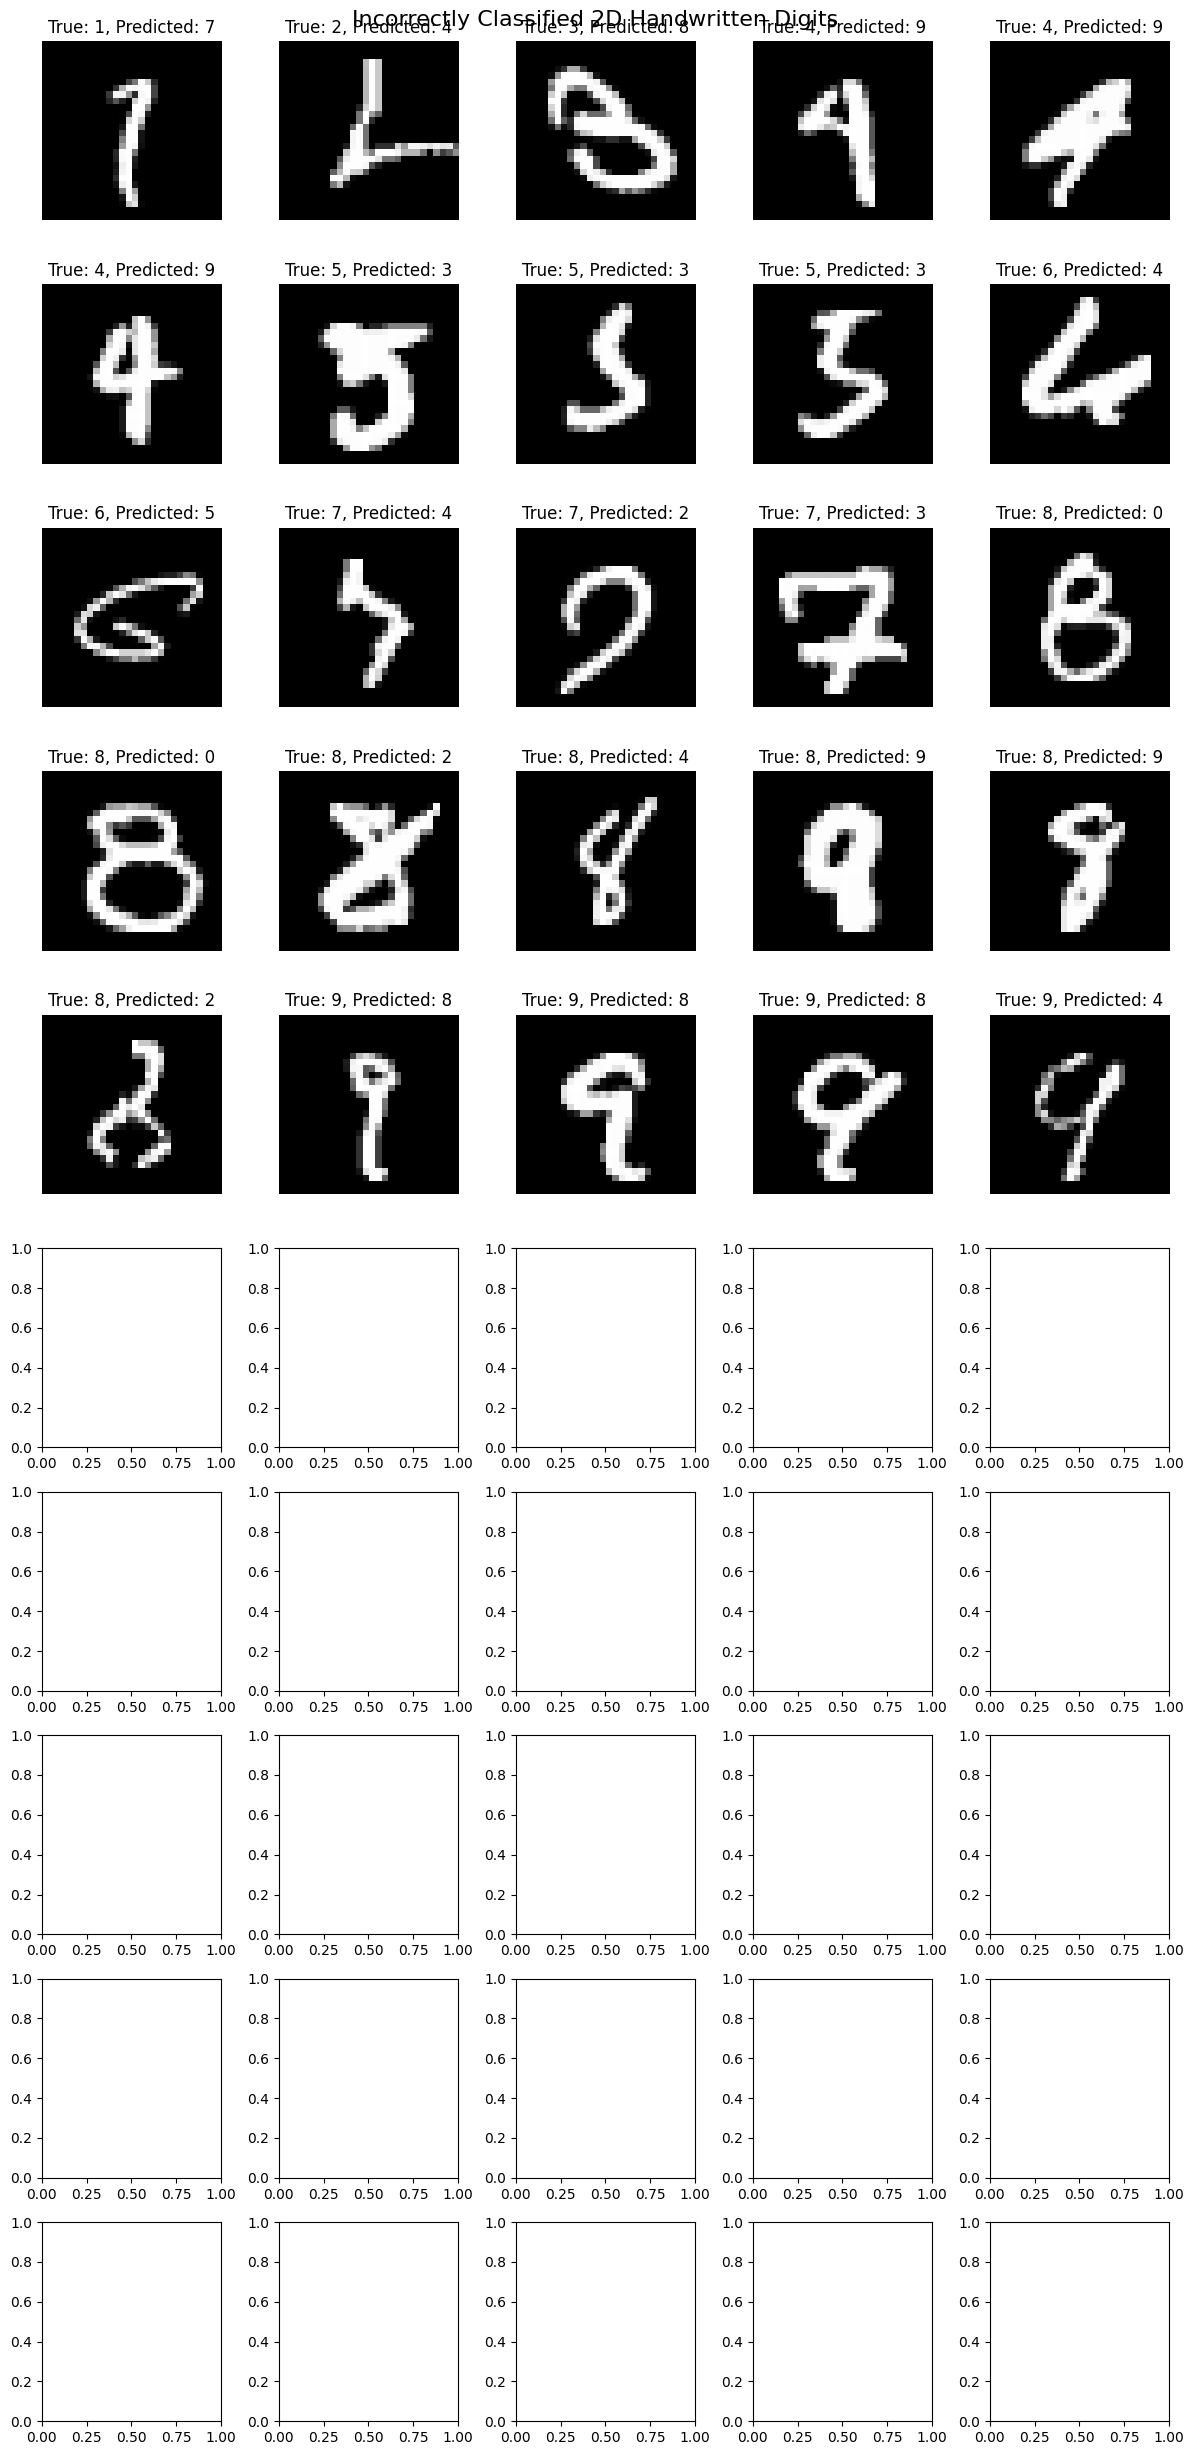

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# Load the model and test set
model = network  # Your trained model
test_dir = 'Test/'  # Directory path containing test images

test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the pixel values

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 200),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test set
predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_set.classes

# Find the indices of incorrectly classified samples
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Display the incorrectly classified samples
num_images = 50  # Number of images to display
num_rows = int(np.ceil(num_images / 5))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, 5, figsize=(12, 2.5 * num_rows))
fig.suptitle('Incorrectly Classified 2D Handwritten Digits', fontsize=16)

for i, index in enumerate(incorrect_indices[:num_images]):
    image_path = test_set.filepaths[index]
    image = load_img(image_path)
    row_idx = i // 5
    col_idx = i % 5
    axes[row_idx, col_idx].imshow(image)
    axes[row_idx, col_idx].set_title(f'True: {true_labels[index]}, Predicted: {predicted_labels[index]}')
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

Found 1000 images belonging to 10 classes.
1000/1000 [==============================] - 2s 2ms/step


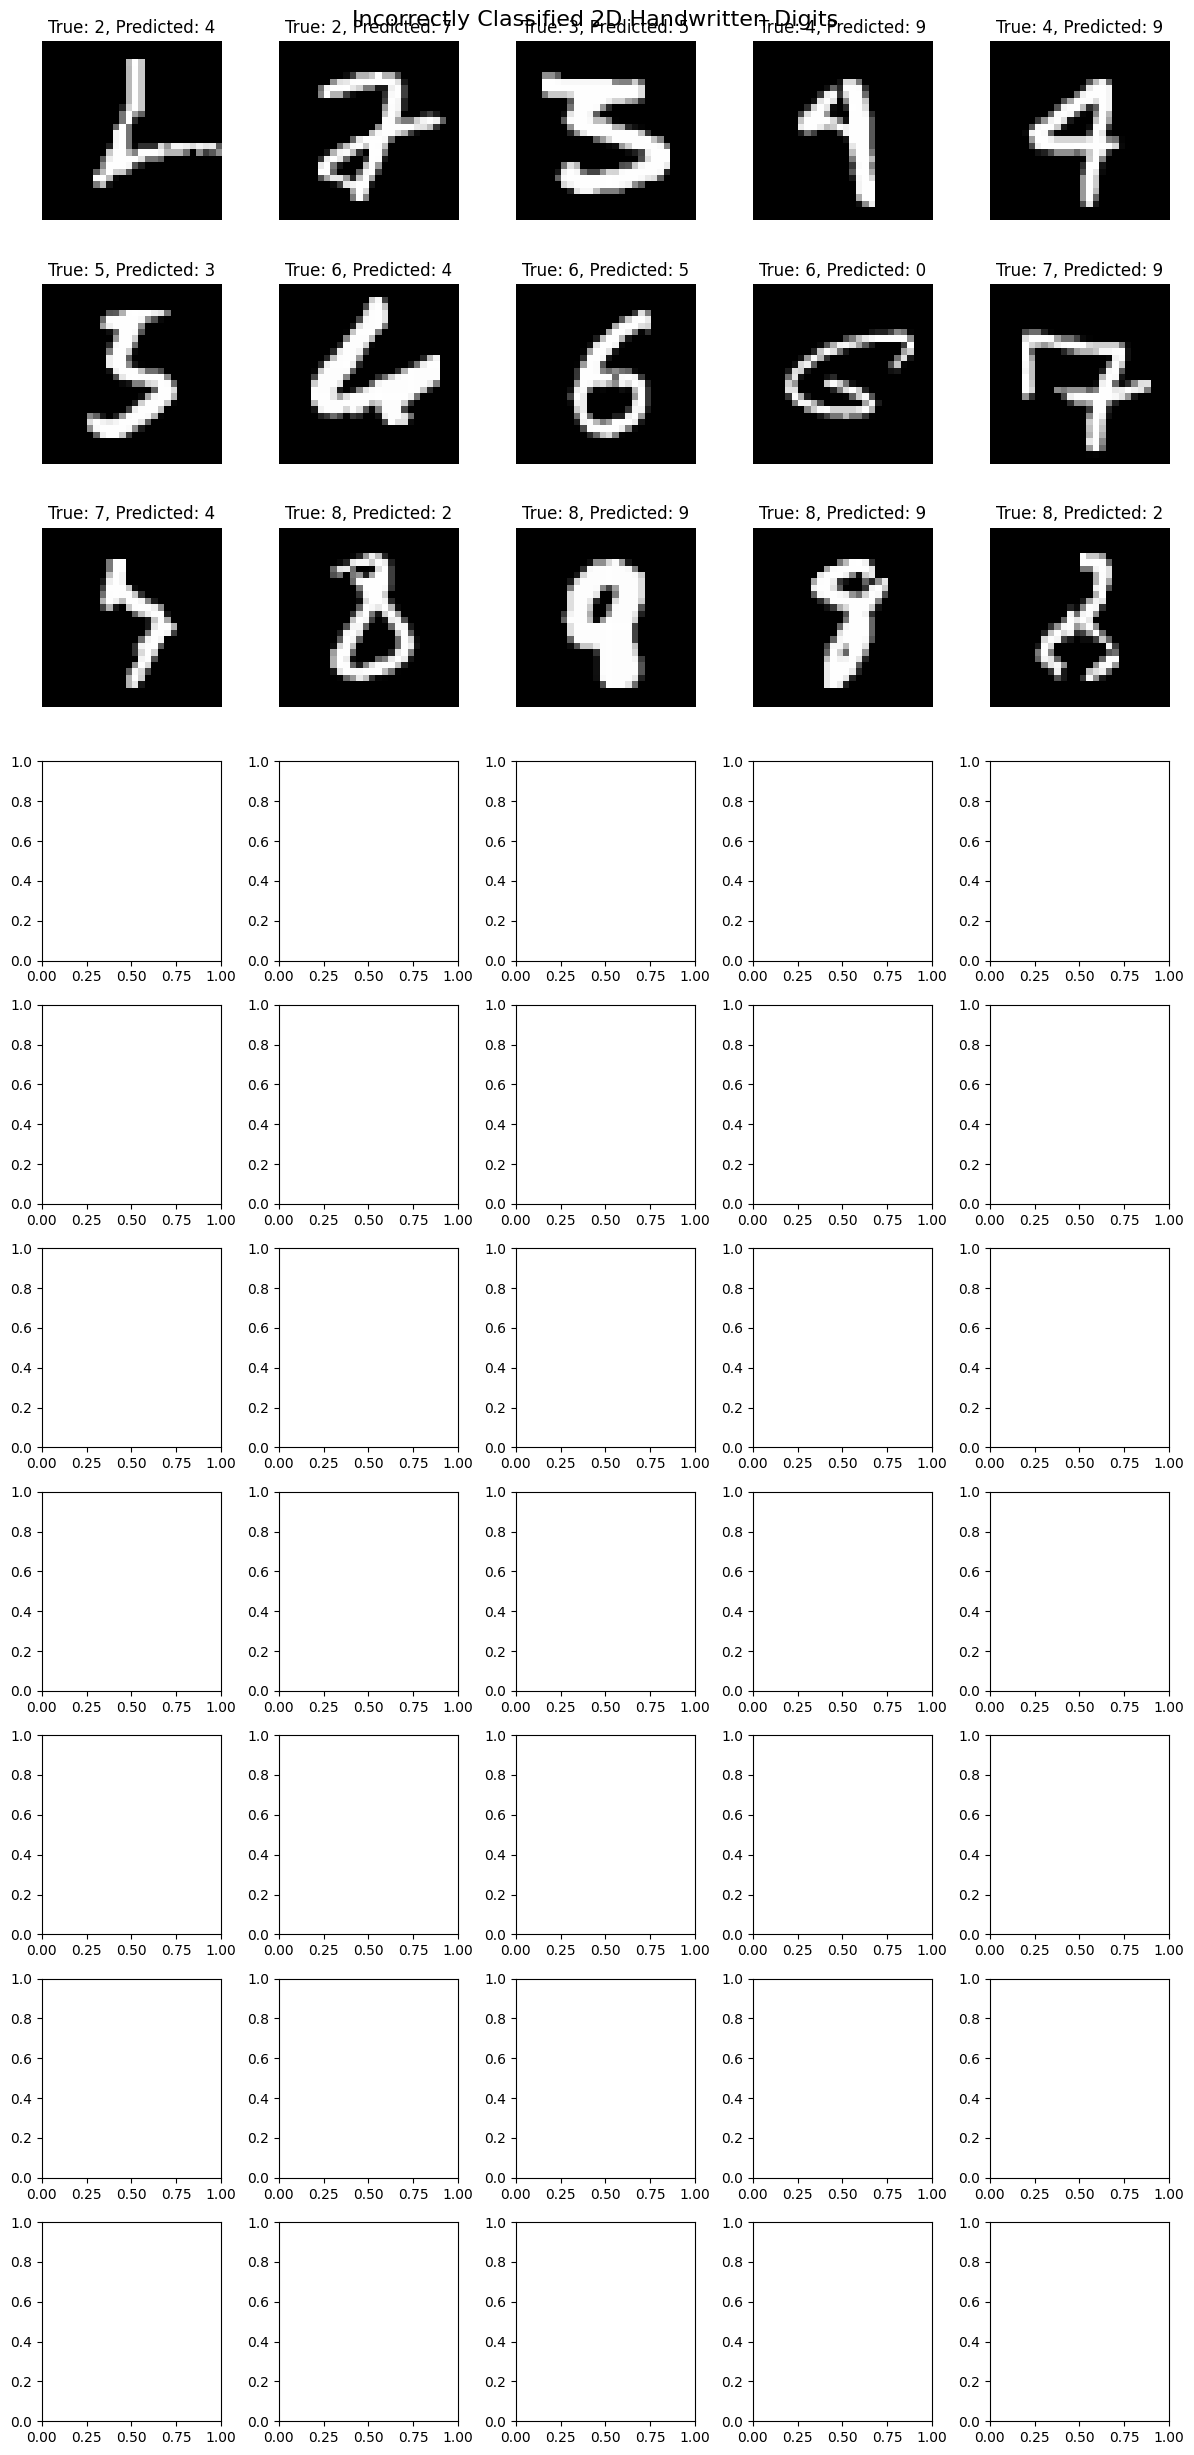

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# Load the best model and test set
best_model = ensemble_models[best_model_index]  # Your best trained model
test_dir = 'D:/ALI REZA/Deep Learning Final Project/ENDING/final_project_dataset/final_project_dataset/Test'  # Directory path containing test images

test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the pixel values

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test set using the best model
predictions = best_model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_set.classes

# Find the indices of incorrectly classified samples
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Display the incorrectly classified samples
num_images = 50  # Number of images to display
num_rows = int(np.ceil(num_images / 5))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, 5, figsize=(12, 2.5 * num_rows))
fig.suptitle('Incorrectly Classified 2D Handwritten Digits', fontsize=16)

for i, index in enumerate(incorrect_indices[:num_images]):
    image_path = test_set.filepaths[index]
    image = load_img(image_path)
    row_idx = i // 5
    col_idx = i % 5
    axes[row_idx, col_idx].imshow(image)
    axes[row_idx, col_idx].set_title(f'True: {true_labels[index]}, Predicted: {predicted_labels[index]}')
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
